Author: Yolanda Pan

Date: 12/11/2025

In [3]:
import os
import pandas as pd
import numpy as np

from scipy.stats import pearsonr
import statsmodels.formula.api as smf
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt
import networkx as nx
import seaborn as sns


In [4]:
INPUT_DATA_PATH = '/project/macs40123/yolanda/candor_parquet/'

NETWORK_PATH = os.path.join(INPUT_DATA_PATH, 'topic_edges_by_convo.parquet')
ANALYSIS_PATH = 'data/convo_features_outdegree_enjoyable.csv'

In [5]:
# ------------- io helpers -------------
def read_parquet_any(path: str) -> pd.DataFrame:
    """
    Read parquet using pyarrow if available, else fastparquet.
    """
    try:
        return pd.read_parquet(path, engine="pyarrow")
    except Exception:
        return pd.read_parquet(path, engine="fastparquet")


def write_parquet_any(df: pd.DataFrame, path: str) -> None:
    """
    Write parquet using pyarrow if available, else fastparquet.
    """
    try:
        df.to_parquet(path, engine="pyarrow", index=False)
    except Exception:
        df.to_parquet(path, engine="fastparquet", index=False)


## Main Effect

In [6]:
df = pd.read_csv(ANALYSIS_PATH)
df.head()

,convo_id,avg_out_degree,n_nodes,avg_how_enjoyable,conv_length_min,n_participants,sex_pair
0,0020a0c5-1658-4747-99c1-2839e736b481,1.562500,16,8.5,43.0,2,FM
1,002d68da-7738-4177-89d9-d72ae803e0e4,1.111111,9,8.0,34.0,2,FM
2,00411458-8275-4b92-a000-d52187f03604,1.428571,7,7.5,35.0,2,FM
3,00ae2f18-9599-4df6-8e3a-6936c86b97f0,1.375000,8,8.0,30.0,2,FF
4,00b410f7-8b5f-4404-8433-0fb8c4be8f62,1.333333,9,7.0,30.0,2,FM


In [7]:
scaler = StandardScaler()

df[["avg_out_degree_z", "n_nodes_z"]] = scaler.fit_transform(
    df[["avg_out_degree", "n_nodes"]]
)

In [8]:
print(df.describe())
print(df.isna().mean())


       avg_out_degree      n_nodes  avg_how_enjoyable  conv_length_min  \
count     1655.000000  1655.000000        1653.000000      1655.000000   
mean         1.276967     8.864653           7.413188        29.019940   
std          0.227243     2.368894           1.183726         8.256372   
min          0.750000     2.000000           1.500000         0.000000   
25%          1.111111     7.000000           7.000000        26.000000   
50%          1.250000     9.000000           7.500000        27.000000   
75%          1.428571    10.000000           8.500000        30.000000   
max          2.333333    20.000000           9.000000        88.000000   

       n_participants  avg_out_degree_z     n_nodes_z  
count          1655.0      1.655000e+03  1.655000e+03  
mean              2.0     -2.420353e-16 -1.674391e-16  
std               0.0      1.000302e+00  1.000302e+00  
min               2.0     -2.319662e+00 -2.898706e+00  
25%               2.0     -7.300842e-01 -7.873785e-01

In [9]:
df = df.dropna(subset=["avg_out_degree", "n_nodes", "avg_how_enjoyable"])

In [10]:
print(df.describe())
print(df.isna().mean())

       avg_out_degree      n_nodes  avg_how_enjoyable  conv_length_min  \
count     1653.000000  1653.000000        1653.000000      1653.000000   
mean         1.276975     8.866909           7.413188        29.032668   
std          0.227351     2.369183           1.183726         8.252347   
min          0.750000     2.000000           1.500000         0.000000   
25%          1.111111     7.000000           7.000000        26.000000   
50%          1.250000     9.000000           7.500000        27.000000   
75%          1.428571    10.000000           8.500000        30.000000   
max          2.333333    20.000000           9.000000        88.000000   

       n_participants  avg_out_degree_z    n_nodes_z  
count          1653.0       1653.000000  1653.000000  
mean              2.0          0.000033     0.000953  
std               0.0          1.000780     1.000424  
min               2.0         -2.319662    -2.898706  
25%               2.0         -0.730084    -0.787379  
50%

In [11]:
corr_vars = df[["avg_how_enjoyable", "avg_out_degree", "n_nodes","conv_length_min"]]
corr_matrix = corr_vars.corr(method="pearson")
print(corr_matrix)

                   avg_how_enjoyable  avg_out_degree   n_nodes  \
avg_how_enjoyable           1.000000        0.135427  0.134666   
avg_out_degree              0.135427        1.000000  0.209455   
n_nodes                     0.134666        0.209455  1.000000   
conv_length_min             0.220739        0.279877  0.292230   

                   conv_length_min  
avg_how_enjoyable         0.220739  
avg_out_degree            0.279877  
n_nodes                   0.292230  
conv_length_min           1.000000  


### Figures

In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from scipy.stats import sem, t

def clean_style(ax):
    ax.set_facecolor("white")
    for spine in ax.spines.values():
        spine.set_visible(False)
    ax.tick_params(axis="both", length=0)
    ax.grid(True, axis="y", linewidth=0.6, alpha=0.18)
    ax.set_axisbelow(True)

def plot_binned_mean_ci(
    x, y, xlabel, ylabel, title,
    *,
    n_bins=8,
    show_raw=True,
    raw_alpha=0.08,
    raw_s=10,
    use_median=False,
    y_limits="auto",        # "auto" | (low, high) | None
    y_pad_frac=0.15,
    x_pad_frac=0.06,
    bootstrap_n=800,
    random_state=0,
    # NEW: colors
    summary_color="black",      # try "black" or "#222222"
    raw_color="#9e9e9e",        # light gray points
):
    mask = x.notna() & y.notna()
    x = x[mask].astype(float)
    y = y[mask].astype(float)

    r, p = pearsonr(x, y)

    bins = pd.qcut(x, q=n_bins, duplicates="drop")
    dfb = pd.DataFrame({"x": x, "y": y, "bin": bins})

    rows = []
    rng = np.random.default_rng(random_state)

    for b, g in dfb.groupby("bin", sort=True):
        yy = g["y"].values
        center = np.median(yy) if use_median else np.mean(yy)

        if use_median:
            boots = np.empty(bootstrap_n)
            for i in range(bootstrap_n):
                boots[i] = np.median(rng.choice(yy, size=len(yy), replace=True))
            lo, hi = np.quantile(boots, [0.025, 0.975])
        else:
            n = len(yy)
            se = sem(yy)
            h = t.ppf(0.975, df=max(n - 1, 1)) * se
            lo, hi = center - h, center + h

        xmid = (b.left + b.right) / 2
        rows.append({"xmid": xmid, "lo": lo, "hi": hi, "center": center})

    summ = pd.DataFrame(rows).sort_values("xmid").reset_index(drop=True)

    fig, ax = plt.subplots(figsize=(6.2, 4.8), facecolor="white")

    if show_raw:
        ax.scatter(
            x.values, y.values,
            s=raw_s,
            alpha=raw_alpha,
            color=raw_color,
            edgecolors="none"
        )

    # mean/median with CI (colored)
    ax.errorbar(
        summ["xmid"], summ["center"],
        yerr=[summ["center"] - summ["lo"], summ["hi"] - summ["center"]],
        fmt="o-",
        color=summary_color,           # line + markers
        ecolor=summary_color,          # error bars
        capsize=3,
        linewidth=2,
        markersize=5,
        markerfacecolor=summary_color,
        markeredgecolor=summary_color
    )

    ax.set_xlabel(xlabel, fontsize=11)
    ax.set_ylabel(ylabel, fontsize=11)
    ax.set_title(title, fontsize=12, pad=8)

    ax.text(
        0.02, 0.98,
        f"$r$ = {r:.2f}, $p$ = {p:.1e}",
        transform=ax.transAxes,
        ha="left", va="top", fontsize=10,
        bbox=dict(facecolor="white", edgecolor="none", alpha=0.9, pad=2.5)
    )

    x_rng = float(x.max() - x.min())
    if x_rng < 1e-12:
        x_rng = 1.0
    ax.set_xlim(x.min() - x_pad_frac * x_rng, x.max() + x_pad_frac * x_rng)

    if y_limits == "auto":
        y_lo = float(summ["lo"].min())
        y_hi = float(summ["hi"].max())
        y_rng = y_hi - y_lo
        if y_rng < 1e-12:
            y_rng = 1.0
        pad = y_pad_frac * y_rng
        ax.set_ylim(y_lo - pad, y_hi + pad)
    elif isinstance(y_limits, tuple) and len(y_limits) == 2:
        ax.set_ylim(*y_limits)
    elif y_limits is None:
        pass
    else:
        raise ValueError('y_limits must be "auto", a (low, high) tuple, or None.')

    clean_style(ax)
    plt.tight_layout()
    plt.show()


/home/xpan02/ipykernel_4084694/2519170019.py:44: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for b, g in dfb.groupby("bin", sort=True):


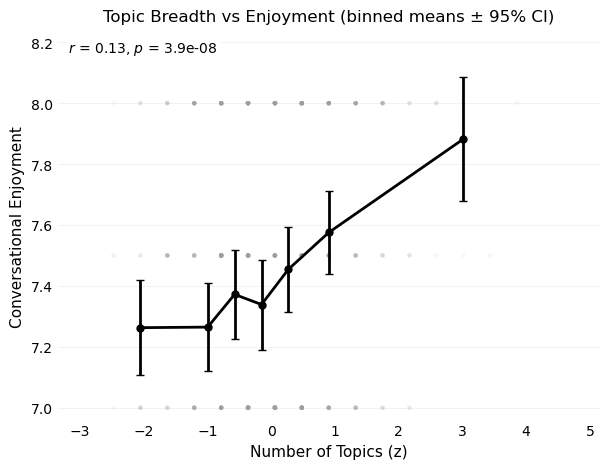

In [13]:
plot_binned_mean_ci(
    df["n_nodes_z"], df["avg_how_enjoyable"],
    xlabel="Number of Topics (z)",
    ylabel="Conversational Enjoyment",
    title="Topic Breadth vs Enjoyment (binned means ± 95% CI)",
    n_bins=8,
    use_median=False
)

/home/xpan02/ipykernel_4084694/2519170019.py:44: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for b, g in dfb.groupby("bin", sort=True):


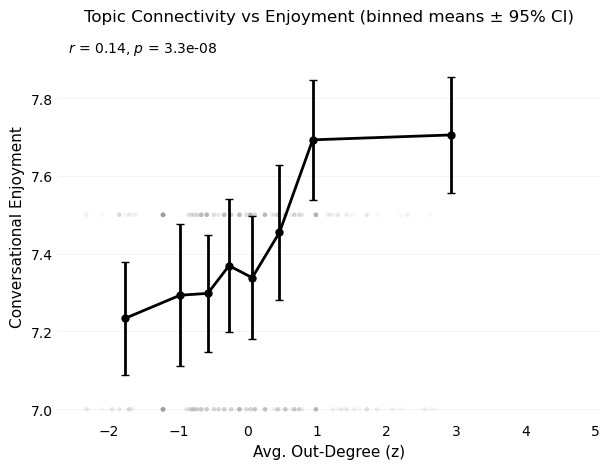

In [14]:
plot_binned_mean_ci(
    df["avg_out_degree_z"], df["avg_how_enjoyable"],
    xlabel="Avg. Out-Degree (z)",
    ylabel="Conversational Enjoyment",
    title="Topic Connectivity vs Enjoyment (binned means ± 95% CI)",
    n_bins=8,
    use_median=False
)


### Models

In [15]:
# ----------------------------
# Model 1:
# avg_how_enjoyable ~ avg_out_degree + n_nodes
# (both standardized)
# ----------------------------
m1 = smf.ols(
    "avg_how_enjoyable ~ avg_out_degree_z + n_nodes_z + conv_length_min + sex_pair",
    data=df
).fit()

print("\nMODEL 1: avg_how_enjoyable ~ avg_out_degree_z + n_nodes_z")
print(m1.summary())



MODEL 1: avg_how_enjoyable ~ avg_out_degree_z + n_nodes_z
                            OLS Regression Results                            
Dep. Variable:      avg_how_enjoyable   R-squared:                       0.067
Model:                            OLS   Adj. R-squared:                  0.064
Method:                 Least Squares   F-statistic:                     19.73
Date:                Wed, 14 Jan 2026   Prob (F-statistic):           2.35e-22
Time:                        08:50:48   Log-Likelihood:                -2566.4
No. Observations:                1653   AIC:                             5147.
Df Residuals:                    1646   BIC:                             5185.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------

In [16]:
# ----------------------------
# Model 2:
# avg_how_enjoyable ~ avg_out_degree
# ----------------------------
m2 = smf.ols(
    "avg_how_enjoyable ~ avg_out_degree_z + conv_length_min + sex_pair",
    data=df
).fit()

print("\nMODEL 2: avg_how_enjoyable ~ avg_out_degree_z")
print(m2.summary())


MODEL 2: avg_how_enjoyable ~ avg_out_degree_z
                            OLS Regression Results                            
Dep. Variable:      avg_how_enjoyable   R-squared:                       0.064
Model:                            OLS   Adj. R-squared:                  0.062
Method:                 Least Squares   F-statistic:                     22.67
Date:                Wed, 14 Jan 2026   Prob (F-statistic):           4.70e-22
Time:                        08:50:48   Log-Likelihood:                -2568.8
No. Observations:                1653   AIC:                             5150.
Df Residuals:                    1647   BIC:                             5182.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------

In [17]:
# ----------------------------
# Model 3:
# avg_how_enjoyable ~ n_nodes
# ----------------------------
m3 = smf.ols(
    "avg_how_enjoyable ~ n_nodes_z + conv_length_min + sex_pair",
    data=df
).fit()

print("\nMODEL 3: avg_how_enjoyable ~ n_nodes_z")
print(m3.summary())



MODEL 3: avg_how_enjoyable ~ n_nodes_z
                            OLS Regression Results                            
Dep. Variable:      avg_how_enjoyable   R-squared:                       0.062
Model:                            OLS   Adj. R-squared:                  0.060
Method:                 Least Squares   F-statistic:                     21.93
Date:                Wed, 14 Jan 2026   Prob (F-statistic):           2.53e-21
Time:                        08:50:53   Log-Likelihood:                -2570.5
No. Observations:                1653   AIC:                             5153.
Df Residuals:                    1647   BIC:                             5186.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
In

#### Interaction

In [18]:
# Model 4: interaction
model_4 = smf.ols(
    "avg_how_enjoyable ~ avg_out_degree_z * n_nodes_z + conv_length_min + sex_pair",
    data=df
).fit()

print(model_4.summary())


                            OLS Regression Results                            
Dep. Variable:      avg_how_enjoyable   R-squared:                       0.069
Model:                            OLS   Adj. R-squared:                  0.065
Method:                 Least Squares   F-statistic:                     17.40
Date:                Wed, 14 Jan 2026   Prob (F-statistic):           2.36e-22
Time:                        10:01:23   Log-Likelihood:                -2564.8
No. Observations:                1653   AIC:                             5146.
Df Residuals:                    1645   BIC:                             5189.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept           

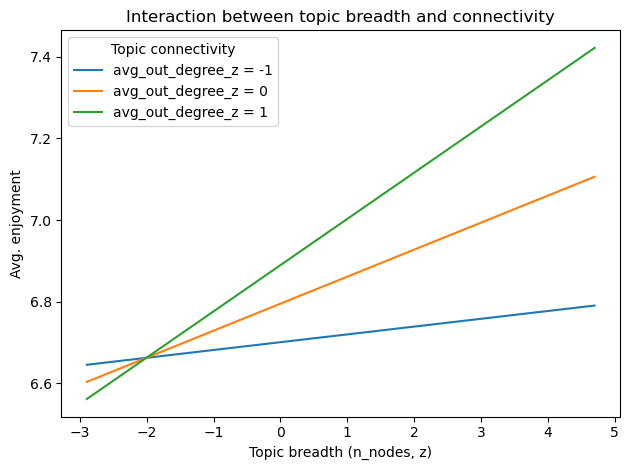

In [19]:
# low / mean / high connectivity
levels = [-1, 0, 1]
x = np.linspace(df["n_nodes_z"].min(), df["n_nodes_z"].max(), 100)

plt.figure()
for lvl in levels:
    y = (
        model_4.params["Intercept"]
        + model_4.params["n_nodes_z"] * x
        + model_4.params["avg_out_degree_z"] * lvl
        + model_4.params["avg_out_degree_z:n_nodes_z"] * x * lvl
    )
    plt.plot(x, y, label=f"avg_out_degree_z = {lvl}")

plt.xlabel("Topic breadth (n_nodes, z)")
plt.ylabel("Avg. enjoyment")
plt.title("Interaction between topic breadth and connectivity")
plt.legend(title="Topic connectivity")
plt.tight_layout()
plt.show()


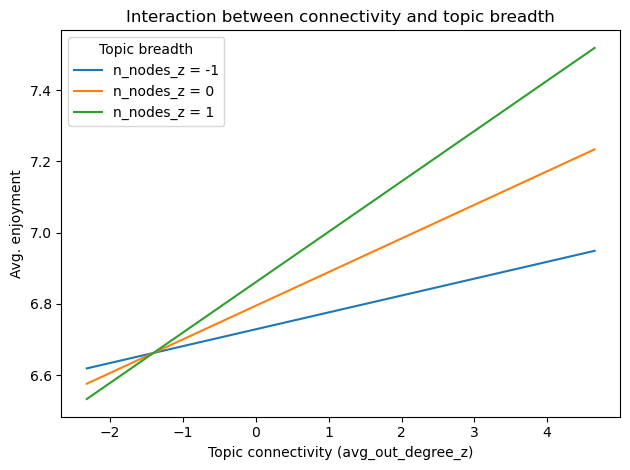

In [20]:
# low / mean / high topic breadth
levels = [-1, 0, 1]
x = np.linspace(df["avg_out_degree_z"].min(), df["avg_out_degree_z"].max(), 100)

plt.figure()
for lvl in levels:
    y = (
        model_4.params["Intercept"]
        + model_4.params["avg_out_degree_z"] * x
        + model_4.params["n_nodes_z"] * lvl
        + model_4.params["avg_out_degree_z:n_nodes_z"] * x * lvl
    )
    plt.plot(x, y, label=f"n_nodes_z = {lvl}")

plt.xlabel("Topic connectivity (avg_out_degree_z)")
plt.ylabel("Avg. enjoyment")
plt.title("Interaction between connectivity and topic breadth")
plt.legend(title="Topic breadth")
plt.tight_layout()
plt.show()


### Visualization

In [21]:
print("N rows:", len(df))
print("Unique (x,y) coords:", df[["n_nodes_z","avg_out_degree_z"]].drop_duplicates().shape[0])


N rows: 1653
Unique (x,y) coords: 124


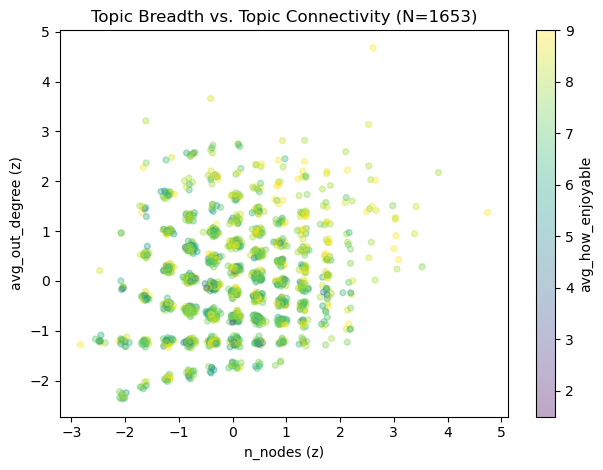

In [22]:
import numpy as np
import matplotlib.pyplot as plt

# jitter helps separate identical coordinates
rng = np.random.default_rng(42)
x = df["n_nodes_z"].to_numpy() + rng.normal(0, 0.05, size=len(df))
y = df["avg_out_degree_z"].to_numpy() + rng.normal(0, 0.05, size=len(df))
c = df["avg_how_enjoyable"].to_numpy()

plt.figure()
sc = plt.scatter(x, y, c=c, alpha=0.35, s=18)  # alpha makes overlap visible
plt.xlabel("n_nodes (z)")
plt.ylabel("avg_out_degree (z)")
plt.title(f"Topic Breadth vs. Topic Connectivity (N={len(df)})")
plt.colorbar(sc, label="avg_how_enjoyable")
plt.tight_layout()
plt.show()


## Networks (within conversation)

In [23]:
def pick_convos_at_quantiles(df: pd.DataFrame, col: str, quantiles=(0.0, 0.25, 0.5, 0.75, 1.0)) -> pd.DataFrame:
    """
    Return a small table with the convo_id closest to each quantile target of df[col].
    """
    if col not in df.columns:
        raise ValueError(f"Column '{col}' not found in convo feature df.")

    d = df[["convo_id", col]].dropna().copy()

    targets = d[col].quantile(list(quantiles)).to_dict()

    rows = []
    for q, target_val in targets.items():
        # pick the real convo whose value is closest to this target
        idx = (d[col] - target_val).abs().idxmin()
        rows.append({
            "quantile": q,
            "target_value": float(target_val),
            "picked_convo_id": d.loc[idx, "convo_id"],
            "picked_value": float(d.loc[idx, col]),
        })

    out = pd.DataFrame(rows).sort_values("quantile").reset_index(drop=True)
    return out


In [24]:
out = pick_convos_at_quantiles(df = df, col = 'avg_out_degree', quantiles=(0.0, 0.25, 0.5, 0.75, 1.0))
out

,quantile,target_value,picked_convo_id,picked_value
0,0.00,0.750000,164bdd54-904f-4308-8d4e-90ba75777e31,0.750000
1,0.25,1.111111,002d68da-7738-4177-89d9-d72ae803e0e4,1.111111
2,0.50,1.250000,030c76ab-9e19-4b78-9a7a-86cd7ba8472a,1.250000
3,0.75,1.428571,00411458-8275-4b92-a000-d52187f03604,1.428571
4,1.00,2.333333,0e9c68be-efc0-40cf-8a9e-06f818063cb9,2.333333


In [25]:
edges_all = read_parquet_any(NETWORK_PATH)
edges_all


PermissionError: [Errno 13] Permission denied: '/project/macs40123/yolanda/candor_parquet/topic_edges_by_convo.parquet'

In [ ]:
edges_all.columns.tolist()


In [26]:
def build_nx_graph(edges_df: pd.DataFrame,
                   source_col="source_topic",
                   target_col="target_topic",
                   weight_col=None,
                   directed=True) -> nx.Graph:
    """
    Build a NetworkX graph from an edges dataframe.
    """
    G = nx.DiGraph() if directed else nx.Graph()

    if weight_col and weight_col in edges_df.columns:
        for s, t, w in edges_df[[source_col, target_col, weight_col]].itertuples(index=False):
            if pd.isna(s) or pd.isna(t):
                continue
            G.add_edge(str(s), str(t), weight=float(w))
    else:
        for s, t in edges_df[[source_col, target_col]].itertuples(index=False):
            if pd.isna(s) or pd.isna(t):
                continue
            G.add_edge(str(s), str(t))

    return G

In [27]:
def draw_graph_pretty(
    G,
    title=None,
    save_path=None,
    seed=42,
    show_labels=True,
    graph_color="#1f77b4",   
):
    plt.figure(figsize=(10, 8))

    pos = nx.spring_layout(G, seed=seed, k=1.8, iterations=200)

    node_size = 720

    # edge widths by weight
    weights = [G[u][v].get("weight", 1.0) for u, v in G.edges()]
    if len(weights) > 0:
        w = np.array(weights)
        edge_widths = 1.2 + 2.5 * (w / (w.max() + 1e-9))
    else:
        edge_widths = 1.5

    nx.draw_networkx_edges(
        G, pos,
        arrows=True,
        arrowstyle="-|>",
        arrowsize=14,
        width=edge_widths,
        alpha=0.8,
        edge_color="#333333",
        connectionstyle="arc3,rad=0.08",
    )

    nx.draw_networkx_nodes(
        G, pos,
        node_size=node_size,
        node_color=graph_color,
        alpha=0.98,
        linewidths=1.8,
        edgecolors="#1a1a1a",
    )

    # labele
    if show_labels:
        nx.draw_networkx_labels(
            G, pos,
            font_size=10,
            font_color="black",
            bbox=dict(
                facecolor="white",
                edgecolor="#cccccc",
                linewidth=0.5,
                alpha=0.9,
                boxstyle="round,pad=0.25"
            ),
        )

    if title:
        plt.title(title, fontsize=12, pad=10)

    plt.axis("off")
    plt.tight_layout()

    if save_path:
        os.makedirs(os.path.dirname(save_path), exist_ok=True)
        plt.savefig(save_path, dpi=300, bbox_inches="tight")

    plt.show()
    plt.close()


In [28]:
QUANTILE_COLORS = {
    0.00: "#1f77b4",  
    0.25: "#2ca02c",  
    0.50: "#ff7f0e",  
    0.75: "#9467bd",  
    1.00: "#d62728",  
}


In [29]:
FIG_DIR = "./figures"

In [ ]:
for _, r in out.iterrows():
    cid = r["picked_convo_id"]
    q = round(r["quantile"], 2)
    val = r["picked_value"]

    edges_df = edges_all[edges_all["conversation_id"] == cid]
    if len(edges_df) == 0:
        continue

    G = build_nx_graph(
        edges_df,
        source_col="source",
        target_col="target",
        weight_col="weight",
        directed=True
    )

    color = QUANTILE_COLORS[q]

    title = f"q={q:.2f}, avg_out_degree={val:.3f}\n{cid}"

    draw_graph_pretty(
        G,
        title=title,
        save_path=os.path.join(FIG_DIR, f"global/q{q:.2f}_network.png"),
        show_labels=False,
        graph_color=color
    )


### same node, diff degree

In [ ]:
def pick_convos_at_quantiles_fixed_nodes(
    df: pd.DataFrame,
    degree_col: str = "avg_out_degree",
    nodes_col: str = "n_nodes",
    target_nodes: int | None = None,
    tol: int = 0,
    quantiles=(0.0, 0.25, 0.5, 0.75, 1.0),
):
    """
    Pick convo_ids at quantiles of degree_col, but only among convos whose node count
    is (target_nodes ± tol). If target_nodes is None, use the median node count.
    """
    for c in ["convo_id", degree_col, nodes_col]:
        if c not in df.columns:
            raise ValueError(f"Missing column: {c}")

    d = df[["convo_id", degree_col, nodes_col]].dropna().copy()

    if target_nodes is None:
        target_nodes = int(d[nodes_col].median())

    subset = d[(d[nodes_col] >= target_nodes - tol) & (d[nodes_col] <= target_nodes + tol)].copy()
    if subset.empty:
        raise ValueError(
            f"No convos found with {nodes_col} in [{target_nodes - tol}, {target_nodes + tol}]. "
            f"Try a larger tol or choose a different target_nodes."
        )

    targets = subset[degree_col].quantile(list(quantiles)).to_dict()

    rows = []
    for q, target_val in targets.items():
        idx = (subset[degree_col] - target_val).abs().idxmin()
        rows.append({
            "quantile": float(q),
            "target_nodes": int(target_nodes),
            "picked_convo_id": subset.loc[idx, "convo_id"],
            "picked_value": float(subset.loc[idx, degree_col]),
            "picked_nodes": int(subset.loc[idx, nodes_col]),
        })

    return pd.DataFrame(rows).sort_values("quantile").reset_index(drop=True)


In [ ]:
out = pick_convos_at_quantiles_fixed_nodes(
    df=df,
    degree_col="avg_out_degree",
    nodes_col="n_nodes",
    target_nodes=None,   # uses median
    tol=0,               # exact same node count
    quantiles=(0, .25, .5, .75, 1)
)
out


In [ ]:
for _, r in out.iterrows():
    cid = r["picked_convo_id"]
    q = round(r["quantile"], 2)
    val = r["picked_value"]

    edges_df = edges_all[edges_all["conversation_id"] == cid]
    if len(edges_df) == 0:
        continue

    G = build_nx_graph(
        edges_df,
        source_col="source",
        target_col="target",
        weight_col="weight",
        directed=True
    )

    color = QUANTILE_COLORS[q]

    title = f"q={q:.2f}, avg_out_degree={val:.3f}\n{cid}"

    draw_graph_pretty(
        G,
        title=title,
        save_path=os.path.join(FIG_DIR, f"9-nodes/q{q:.2f}_network.png"),
        show_labels=False,
        graph_color=color
    )


### same degree, diff nodes

In [ ]:
def pick_convos_at_quantiles_fixed_degree(
    df: pd.DataFrame,
    degree_col: str = "avg_out_degree",
    nodes_col: str = "n_nodes",
    target_degree: float | None = None,
    tol: float = 0.0,
    quantiles=(0.0, 0.25, 0.5, 0.75, 1.0),
):
    """
    Pick convo_ids at quantiles of nodes_col, but only among convos whose degree value
    is (target_degree ± tol). If target_degree is None, use the median degree.
    """
    for c in ["convo_id", degree_col, nodes_col]:
        if c not in df.columns:
            raise ValueError(f"Missing column: {c}")

    d = df[["convo_id", degree_col, nodes_col]].dropna().copy()

    if target_degree is None:
        target_degree = float(d[degree_col].median())

    subset = d[(d[degree_col] >= target_degree - tol) & (d[degree_col] <= target_degree + tol)].copy()
    if subset.empty:
        raise ValueError(
            f"No convos found with {degree_col} in [{target_degree - tol}, {target_degree + tol}]. "
            f"Try a larger tol or choose a different target_degree."
        )

    targets = subset[nodes_col].quantile(list(quantiles)).to_dict()

    rows = []
    for q, target_nodes in targets.items():
        idx = (subset[nodes_col] - target_nodes).abs().idxmin()
        rows.append({
            "quantile": float(q),
            "target_degree": float(target_degree),
            "picked_convo_id": subset.loc[idx, "convo_id"],
            "picked_value": int(subset.loc[idx, nodes_col]),        # picked nodes
            "picked_degree": float(subset.loc[idx, degree_col]),
        })

    return pd.DataFrame(rows).sort_values("quantile").reset_index(drop=True)


In [ ]:
out = pick_convos_at_quantiles_fixed_degree(
    df=df,
    degree_col="avg_out_degree",
    nodes_col="n_nodes",
    target_degree=None,   # uses median degree
    tol=0.0,              # exact same degree; usually you'll want >0
    quantiles=(0, .25, .5, .75, 1)
)
out


In [ ]:
for _, r in out.iterrows():
    cid = r["picked_convo_id"]
    q = round(r["quantile"], 2)

    nodes = r["picked_value"]
    deg = r["picked_degree"]

    edges_df = edges_all[edges_all["conversation_id"] == cid]
    if len(edges_df) == 0:
        continue

    G = build_nx_graph(
        edges_df,
        source_col="source",
        target_col="target",
        weight_col="weight",
        directed=True
    )

    color = QUANTILE_COLORS[q]
    title = f"q={q:.2f}, n_nodes={nodes}, avg_out_degree={deg:.3f}\n{cid}"

    draw_graph_pretty(
        G,
        title=title,
        save_path=os.path.join(FIG_DIR, f"fixed-degree/q{q:.2f}_network.png"),
        show_labels=False,
        graph_color=color
    )
